In [51]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

In [52]:
# FUNCTION: 
# Example call:   tf_variable = get_nn_parameter(...)
def get_nn_parameter(variable_scope, variable_name, dim1, dim2):
    '''
    Used to retrieve or create new NN parameters (weights & biases)
    When calling, the corresponding NNparameter's dimensions need to be specified too.
    Returns a tensorflow variable. Note that NN parameters need to be tensorflow variables
    so that values can be changed whenever needed when training. Also note that it is 
    explicitly defined that the created variable is TRAINABLE.
    '''
    with tf.variable_scope(variable_scope, reuse=tf.AUTO_REUSE):
      v = tf.get_variable(variable_name, 
                          [dim1, dim2], 
                          trainable=True, 
                          initializer = tf.contrib.layers.xavier_initializer())
    return v

In [53]:
# FUNCTION: 
# Example call:   nn_parameters = initialize_layer_parameters([3, 5, 5, 2])
def initialize_layer_parameters(num_units_in_layers):
    '''
    NOTE THAT THE LAST LAYER HAS TO HAVE AT LEAST 2 UNITS BCZ SOFTMAX IS USED IN THIS NN MODEL
    Returns a dictionary of created weights and biases for all layers of the NN.
    Note that # units can vary in each layer.
    Exmaple return: parameters = {"W1": tf_variable_for_W1, "b1": tf_variable_for_b1, ...}
    '''
    
    parameters = {}
    L = len(num_units_in_layers)
     
    for i in range (1, L):
        #print("W" + str(i) + " " + str(num_units_in_layers[i]) + " " + str(num_units_in_layers[i-1]))
        temp_weight = get_nn_parameter("weights",
                                       "W"+str(i), 
                                       num_units_in_layers[i], 
                                       num_units_in_layers[i-1])
        parameters.update({"W" + str(i) : temp_weight})  
        
        #print("b" + str(i) + " " + str(num_units_in_layers[i]) + " " + str(1))
        temp_bias = get_nn_parameter("biases",
                                     "b"+str(i), 
                                     num_units_in_layers[i], 
                                     1)
        parameters.update({"b" + str(i) : temp_bias})  
        
    return parameters

In [54]:
# FUNCTION: 
# Example call: ZL = forward_propagation_with_relu(X_train, [3, 5, 5, 2], nn_parameters)
def forward_propagation_with_relu(X, num_units_in_layers, parameters):
    '''
    Returns ZL, which is the linear output of the output layer (layer L)
    AL is also calculated but it is not returned or used. The optimizer function takes ZL as input, not the AL.
    What activation function is used in output layer plays role when calculating the cost 
    so that you need to call the right cost (or cross entropy) function in compute_cost(...) function
    '''
    L = len(num_units_in_layers)
    
    A_temp = tf.transpose(X)
    for i in range (1, L):
        #W = get_nn_parameter("weights", "W"+str(i), num_units_in_layers[i], num_units_in_layers[i-1])
        W = parameters.get("W"+str(i))
        #b = get_nn_parameter("biases", "b"+str(i), num_units_in_layers[i], 1)
        b = parameters.get("b"+str(i))
        Z_temp = tf.add(tf.matmul(W, A_temp), b)
        A_temp = tf.nn.relu(Z_temp)       # Example: A1 = relu(Z1)1, Note that A in the last (output) 
                                          # layer is irrelevant bcz we return ZL

    return Z_temp   #This is the linear output of last layer

In [55]:
# FUNCTION
# This function requires update if softmax is not used in the output layer
def compute_cost(ZL, Y, parameters, lambd, mb_size):
    """
    This function should be used for multinomial mutually exclusive classification, i.e. pick one out of N classes. 
    Also applicable when N = 2.
    The labels must be one-hot encoded or can contain soft class probabilities: a particular example can belong to
    class A with 50% probability and class B with 50% probability. Note that strictly speaking it doesn't mean that
    it belongs to both classes, but one can interpret the probabilities this way.
    
    Arguments:
    ZL -- output of forward propagation (output of the last LINEAR unit)
    Y -- "true" labels vector placeholder, same shape as ZL
    mb_size -- number of samples in the given mini-batch
    lambd -- lambda regularization parameter (regularization deactivated is lambd=0.)
    
    Returns:
    cost - Tensor of the cost function
    """

    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(ZL)
    labels = Y
    
    # This cost calculation is unregularized. cost = (1/m) sum(Loss(y_hat(i), y(i))), where i = 1,..,mb_size 
    #tf.reduce_mean(..) function finds the mean of costs of examples in the given mini-batch
    cost_unregularized = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = labels))
    
    # Add L2 regularization: cost += (lambd / (2 * mb_size)) * sum(W(i,j)**2), where i:1,..,n[l] and j:1,..,n[l-1] 
    # L:number of layers. Since the dict parameters includes both W and b, it needs to be divided with 2 to find L
    L = len(parameters) // 2
    
    # The list will have L elements, each holding the sum of weight matrix values in each layer. Later, these
    # weight values need to be summed up again
    list_sum_weights = []
    
    for i in range (0, L):
        list_sum_weights.append(tf.nn.l2_loss(parameters.get("W"+str(i+1))))
    
    # in the following calculation, since the l2_loss returns "sum(t ** 2) / 2", where the sum of squares is already
    # divided by 2, there is no need to bultiply the mb_size with 2
    #regularization_effect = (lambd / mb_size) * sum(list_sum_weights)
    regularization_effect = tf.multiply((lambd / mb_size), tf.add_n(list_sum_weights))
    cost = tf.add(cost_unregularized, regularization_effect)
    
    return cost

In [56]:
# UPDATE-1 IN EACH PROJECT (depending on default values for each column)
# Determine default values for each column in case data is missing
record_defaults = [[""], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]

def decode_csv(line):
    parsed_line = tf.decode_csv(line, record_defaults)
    label = parsed_line[-2:]          # last 2 columns are labels
    del parsed_line[-1]               # delete the last element from the list   (label column)
    del parsed_line[-2]               # delete the second last element from the list. (label column)
    del parsed_line[0]                # even delete the first element bcz it is assumed NOT to be a feature
    features = tf.stack(parsed_line)  # Stack features so that you can later vectorize forward prop., etc.
    label = tf.stack(label)           # Needed bcz labels consist of 2 columns
    batch_to_return = features, label

    return batch_to_return


In [67]:
def nn_model(train_input_paths, dev_input_paths, test_input_paths, learning_rate, num_train_epochs, 
             epoch_period_to_save_cost, minibatch_size, num_units_in_layers, lambd, print_progress):
    """
    Returns NN parameters after the completion of training.
    """

    tf.reset_default_graph()     # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)       # tf.reset_default_graph() needs to be run first before calling tf.set_random_seed(..)
    
    costs_train = []                                        # To keep track of the cost
    accuracies_train = []
    costs_dev = []
    accuracies_dev = []
    
    #shuffle = True
    num_epochs= num_train_epochs
    input_paths = train_input_paths
    
    with tf.name_scope("init_nn_params"):
        # Initialize parameters
        parameters = initialize_layer_parameters(num_units_in_layers)    

    with tf.name_scope("next_train_batch"):
        filenames = tf.placeholder(tf.string, shape=[None])
        dataset = tf.data.Dataset.from_tensor_slices(filenames)
        dataset = dataset.flat_map(lambda filename: tf.data.TextLineDataset(filename).skip(1).map(decode_csv))
        dataset = dataset.shuffle(buffer_size=1000)
        dataset = dataset.batch(minibatch_size)
        iterator = dataset.make_initializable_iterator()
        X_mini_batch, Y_mini_batch = iterator.get_next()

    with tf.name_scope("forward_prop"):
        # Forward propagation: Build the forward propagation in the tensorflow graph
        ZL = forward_propagation_with_relu(X_mini_batch, num_units_in_layers, parameters)

    with tf.name_scope("calc_cost"):
        # Cost function: Add cost function to tensorflow graph
        cost_mini_batch = compute_cost(ZL, Y_mini_batch, parameters, lambd, 
                                       mb_size=tf.cast(X_mini_batch.shape[1], dtype=tf.float32))

    with tf.name_scope("train"):
        # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
        optimizer =  tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost_mini_batch)

    with tf.name_scope("evaluation"):
        # Size of labels is (nr_examples, nr_of_classes)
        # Size of logits (ZL) is (nr_of_classes, nr_of_examples)

        # Find the index of max value for each (training/dev/test) sample
        Y_argmax = tf.argmax(Y_mini_batch, 1)

        # Check if indexes of max value for each train/dev/test samples are the same with that of "y" ("labels")
        are_predictions_correct = tf.nn.in_top_k(tf.transpose(ZL), Y_argmax, 1)  # Example output: [True, False, True, ...]
        accuracy_mini_batch = tf.reduce_mean(tf.cast(are_predictions_correct, tf.float32))
    
    # Initialize all the variables
    init_global_var = tf.global_variables_initializer() 
    init_local_var = tf.local_variables_initializer()   

    # Define a saver to save session params periodically
    saver = tf.train.Saver(max_to_keep=500)
    #saver = tf.train.Saver(var_list=tf.trainable_variables())
    
    # sess is created fo the training phase
    with tf.Session() as sess:
        #print(sess.graph)
        sess.run(init_global_var)
        # initializing local variables needed to be able to set num_epochs
        sess.run(init_local_var)

        epoch_nr = 0
        for _ in range(num_train_epochs // epoch_period_to_save_cost): 
            sum_minibatch_costs = 0
            sum_minibatch_accuracies = 0
            nr_of_minibatches = 0
            # Train epoch_period_to_save_cost epochs. Then validate train set. Then validate dev set.
            for _ in range(epoch_period_to_save_cost):     
                sess.run(iterator.initializer, feed_dict={filenames: train_input_paths})
                while True:
                    try:
                      _ , minibatch_cost, accuracy_mb_train = sess.run([optimizer, 
                                                                        cost_mini_batch, 
                                                                        accuracy_mini_batch])
                      nr_of_minibatches += 1
                      sum_minibatch_costs += minibatch_cost
                      sum_minibatch_accuracies += accuracy_mb_train
                    except tf.errors.OutOfRangeError:
                      epoch_nr += 1
                      #print("Out of range error triggered (looped through training set 1 time)")
                      break
            # Note that cost and accuracy reporting is done on the entire train set, not based on a subset
            current_cost_train = sum_minibatch_costs / nr_of_minibatches
            current_accuracy_train = sum_minibatch_accuracies / nr_of_minibatches
            costs_train.append(current_cost_train)
            accuracies_train.append(current_accuracy_train)
            if print_progress:
                print ("TRAIN: After epoch %i: Cost: %f   Accuracy: %f" % 
                       (epoch_nr, current_cost_train, current_accuracy_train))
            


            sum_minibatch_costs = 0
            sum_minibatch_accuracies = 0
            nr_of_minibatches = 0
            sess.run(iterator.initializer, feed_dict={filenames: dev_input_paths})
            while True:
                try:
                  minibatch_cost, accuracy_mb_dev = sess.run([cost_mini_batch, 
                                                              accuracy_mini_batch])
                  nr_of_minibatches += 1
                  sum_minibatch_costs += minibatch_cost
                  sum_minibatch_accuracies += accuracy_mb_dev
                except tf.errors.OutOfRangeError:
                  #print("Out of range error triggered (looped through dev set 1 time only)")
                  break        
            # Note that cost and accuracy reporting is done on the entire dev set, not based on a subset
            current_cost_dev = sum_minibatch_costs / nr_of_minibatches
            current_accuracy_dev = sum_minibatch_accuracies / nr_of_minibatches
            costs_dev.append(current_cost_dev)
            accuracies_dev.append(current_accuracy_dev)
            if print_progress:
                print ("DEV:   After epoch %i: Cost: %f   Accuracy: %f\n" % 
                       (epoch_nr, current_cost_dev, current_accuracy_dev))
    
            # Save the model periodically (after each epoch_period_to_save_cost epochs)
            dir = os.path.join("./checkpoint_dir", "my_nn_model")
            finfo = saver.save(sess, dir, global_step=epoch_nr)  
            #print(str(epoch_nr) + "  " + finfo + "\n")

        parameters = sess.run(parameters)
        
        # Training is completed at this point.
        #Calculate test set cost & accuracy. Improving test set cost is not the target here.Just further information..
        sum_minibatch_costs = 0
        sum_minibatch_accuracies = 0
        nr_of_minibatches = 0
        sess.run(iterator.initializer, feed_dict={filenames: test_input_paths})
        j = 0
        while True:
            try:
              minibatch_cost, accuracy_mb_test = sess.run([cost_mini_batch, 
                                                           accuracy_mini_batch])
              nr_of_minibatches += 1
              sum_minibatch_costs += minibatch_cost
              sum_minibatch_accuracies += accuracy_mb_test
            except tf.errors.OutOfRangeError:
              #print("Out of range error triggered (looped through test set 1 time only)")
              break   
        cost_test = sum_minibatch_costs / nr_of_minibatches
        accuracy_test = sum_minibatch_accuracies / nr_of_minibatches
        print("TEST: Cost: %f   --   Accuracy: %f" % (cost_test, accuracy_test))
        
    # plot the cost
    plt.plot(np.squeeze(costs_train))
    plt.plot(np.squeeze(costs_dev))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    # Print the accuracy
    plt.plot(np.squeeze(accuracies_train))
    plt.plot(np.squeeze(accuracies_dev))
    plt.ylabel('Accuracy')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    print("costs_train")
    print(costs_train)
    print("costs_dev")
    print(costs_dev)
    
    return parameters

TRAIN: After epoch 10: Cost: 1.124786   Accuracy: 0.520408
DEV:   After epoch 10: Cost: 0.815574   Accuracy: 0.690476

TRAIN: After epoch 20: Cost: 0.644555   Accuracy: 0.658163
DEV:   After epoch 20: Cost: 0.827915   Accuracy: 0.309524

TRAIN: After epoch 30: Cost: 0.594076   Accuracy: 0.708163
DEV:   After epoch 30: Cost: 0.782534   Accuracy: 0.619048

TRAIN: After epoch 40: Cost: 0.433404   Accuracy: 0.861224
DEV:   After epoch 40: Cost: 0.392082   Accuracy: 0.761905

TRAIN: After epoch 50: Cost: 0.222033   Accuracy: 0.991837
DEV:   After epoch 50: Cost: 0.147300   Accuracy: 1.000000

TRAIN: After epoch 60: Cost: 0.113090   Accuracy: 1.000000
DEV:   After epoch 60: Cost: 0.063778   Accuracy: 1.000000

TRAIN: After epoch 70: Cost: 0.070973   Accuracy: 1.000000
DEV:   After epoch 70: Cost: 0.043024   Accuracy: 1.000000

TRAIN: After epoch 80: Cost: 0.051221   Accuracy: 1.000000
DEV:   After epoch 80: Cost: 0.031511   Accuracy: 1.000000

TEST: Cost: 0.053305   --   Accuracy: 1.000000


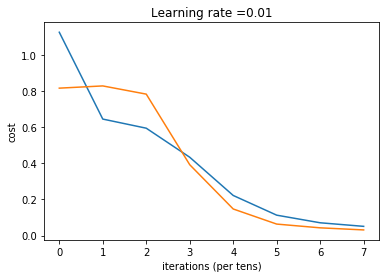

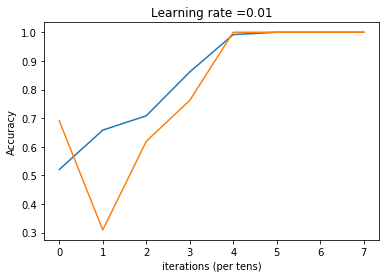

costs_train
[1.1247864369835172, 0.6445550318275179, 0.5940757180963244, 0.43340379553181785, 0.2220326837684427, 0.11308956891298294, 0.07097292632928916, 0.05122051313519478]
costs_dev
[0.815573513507843, 0.8279154002666473, 0.7825337648391724, 0.3920820504426956, 0.14729951322078705, 0.0637780912220478, 0.04302438721060753, 0.03151135239750147]
{'W1': array([[-9.7198470e-05, -2.2575287e-03,  1.3157876e-02,  7.1284031e-03,
         4.8003731e+00]], dtype=float32), 'W2': array([[1.4983103 ],
       [0.02857272]], dtype=float32), 'b1': array([[-0.04495152]], dtype=float32), 'b2': array([[-0.6047769],
       [ 1.8712997]], dtype=float32)}


In [70]:
# NOTE1: Whenever you need to use the framework, you need to update the list of record_defaults that defines
# default values for empty cells in the csv file. Go to decode_csv file to update it.
# NOTE2: Only numerical data is supported right now in the excel file.

# Hyper parameters and optimization parameters
learning_rate = 0.01
num_train_epochs = 80
minibatch_size = 4
epoch_period_to_save_cost = 10   # After how many epochs do you want to save cost & accuracy?
num_units_in_layers = [5,1,2] 
lambd = 0.
print_progress = True

# Data may reside in several files. 2 is created here for illustration purposes
train_path1 = "train1.csv"
train_path2 = "train2.csv"
dev_path1 = "dev1.csv"
test_path1 = "test1.csv"
train_input_paths = [train_path1, train_path2]
dev_input_paths = [dev_path1]
test_input_paths = [test_path1]

parameters = nn_model(train_input_paths, dev_input_paths, test_input_paths, learning_rate, num_train_epochs, 
                      epoch_period_to_save_cost, minibatch_size, num_units_in_layers, lambd, print_progress)

print(parameters)

In [ ]:
#TODO
# Implement accuracy calculation (on train and test sets)  -- DONE!
# Implement using CSV file(s) even for test data to calculate test accuracy  - DONE!
# Add normalization to input params in layer=0
# Add batch normalization   (check what needs to be done for gradient calculations)
# Dropout
# Can we use tf.layers.dense(...) for forward propagation?
# Check tensorboard and if you have given appropriate names to your tensors
# Can we use ELU instead of RELU? ELU function has a parameter called alpha that needs to be tuned. The common 
# practice for ELU is to set alpha to 1. (Probably changing it doesnt give that much gain)
# Implement a new program that restores the latest model, takes an input and makes a prediction


abc = []
abc.append(1)
abc.append(5)
print(abc)
print(sum(abc))

In [ ]:
der = np.array([3,3,3])
print(len(der))